# Injury Prediction Modeling Notebook

# Step 1: Load Libraries

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import optuna
from optuna.samplers import TPESampler

c:\Users\Furka\anaconda3\envs\llm4ts\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 2: Load Data

In [44]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [45]:
print(f"Number of null values in train set:{df_train.isna().sum()}")

Number of null values in train set:Player                   0
Player ID                0
Season                   0
Injury                   0
From                     0
Days Out                 0
Games Missed             0
Club                     0
Appearances              0
League                   0
Minutes Played           0
is_injurydata_missing    0
target                   0
dtype: int64


In [46]:
print(f"Number of null values in test set:{df_test.isna().sum()}")

Number of null values in test set:Player                   0
Player ID                0
Season                   0
Injury                   0
From                     0
Days Out                 0
Games Missed             0
Club                     0
Appearances              0
League                   0
Minutes Played           0
is_injurydata_missing    0
target                   0
dtype: int64


In [47]:
print("Days Out:", df_train.loc[df_train['Days Out']<0].shape)
print("Games Missed:", df_train.loc[df_train['Games Missed']<0].shape)
print("target:", df_train.loc[df_train['target']<0].shape)
print("Appearances:", df_train.loc[df_train['Appearances']<0].shape)
print("is_injurydata_missing':", df_train.loc[df_train['is_injurydata_missing']==1].shape)


Days Out: (0, 13)
Games Missed: (0, 13)
target: (0, 13)
Appearances: (131, 13)
is_injurydata_missing': (131, 13)


# Step 3: Feature Engineering

In [48]:
def target_encoding(df, col, target_col='target', min_samples=1):
    encoding_map = df.groupby(col)[target_col].agg(['mean', 'count'])
    encoding_map = encoding_map.loc[encoding_map['count'] >= min_samples, 'mean'].to_dict()
    return df[col].map(encoding_map).fillna(df[target_col].mean())


In [75]:
def feature_engineering(df, apply_target_encoding=True):
    df['From'] = pd.to_datetime(df['From'], errors='coerce')

    # Create temporal features
    df['Year'] = df['From'].dt.year
    df['Month'] = df['From'].dt.month
    df['Day'] = df['From'].dt.day
    df['Weekday'] = df['From'].dt.weekday

    # Duration ratios
    df['Days_per_Game'] = df['Days Out'] / (df['Games Missed'] + 1)
    df['Minutes_per_Appearance'] = df['Minutes Played'] / (df['Appearances'] + 2)

    # Time since last game
    df['Days_Since_Last_Game'] = (pd.to_datetime('today') - df['From']).dt.days

    # Injury-related features
    df['Injury_Severity'] = df['Days Out'] / (df['Appearances'] + 2)

    # Cumulative injury history
    df['Injuries_in_League'] = df.groupby('League')['target'].cumsum() - df['target']
    df['Previous_Total_Injuries'] = df.groupby('Player ID')['target'].cumsum() - df['target']
    df['Previous_Season_Injuries'] = df[df['Season'] < df['Season'].max()].groupby('Player ID')['target'].transform('sum')

    # Target and label encoding for categorical features
    categorical_cols = ['Club', 'League', 'Season']
    encoder = LabelEncoder()
    for col in categorical_cols:
        df[f'{col}_LE'] = encoder.fit_transform(df[col].astype(str))
        if col in ['Club', 'League'] and apply_target_encoding:
            df[f'{col}_TE'] = target_encoding(df, col)

    df.drop(columns=categorical_cols, inplace=True)
    return df

In [80]:
# Apply Feature Engineering
train = feature_engineering(df_train.copy(), apply_target_encoding=True)
test = feature_engineering(df_test.copy(), apply_target_encoding=True)

# Step 4: Prepare Data for Modeling
train_sorted = train.sort_values(by=['From', 'Player ID']).reset_index(drop=True)
X_train = train_sorted.drop(['target', 'Injury', 'Player', 'Player ID', 'From'], axis=1)
y_train = train_sorted['target']
X_test = test.drop(['target', 'Injury', 'Player', 'Player ID', 'From'], axis=1)
y_test = test['target']

# Step-4: Cross-Validation and Hyperparameter Tuning

In [95]:
def cross_validate_model(model, X, y, dates, cv_method='time_series'):
    if cv_method == 'time_series':
        cv = TimeSeriesSplit(n_splits=5)
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        val_dates = dates.iloc[val_idx]
        
        # Calculate class distribution in the validation set
        pos_ratio = y_val_fold.sum() / len(y_val_fold)
        neg_ratio = 1 - pos_ratio
        print(f"Fold {fold + 1}: Positive Ratio = {pos_ratio:.2f}, Negative Ratio = {neg_ratio:.2f}")
        print(f"Date Range: {val_dates.min().date()} to {val_dates.max().date()}")
        
        model.fit(X_train_fold, y_train_fold)
        y_pred_val = model.predict(X_val_fold)
        evaluate_model(y_val_fold, y_pred_val)


# Evaluation Function
def evaluate_model(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    metrics_df = pd.DataFrame(
        classification_report(y_true, y_pred, output_dict=True)).transpose()
    metrics_df['accuracy_score'] = accuracy_score(y_true, y_pred)

    print("Evaluation Metrics:\n", metrics_df)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return metrics_df


In [126]:
# LightGBM-Specific Cross-Validation Function
def cross_val_train_optuna(X, y, model_class, param_space):
    """
    Perform hyperparameter optimization using Optuna for LightGBM
    while maximizing Gini score.
    """
    def objective(trial):
        params = param_space(trial)
        cv = TimeSeriesSplit(n_splits=3)
        scores = []
        for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            model = model_class(**params)
            model.fit(X_train_fold, y_train_fold)
            y_pred_val = model.predict(X_val_fold)
            y_pred_val_prob = model.predict_proba(X_val_fold)[:, 1]
            score = roc_auc_score(y_val_fold, y_pred_val_prob)
            scores.append(score)
        avg_score = np.mean(scores)
        return avg_score
    # Optuna Study
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=10)
    # Return Best Parameters and Score
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best Parameters for RandomForest: {best_params}")
    print(f"Best AUC-Score for RandomForest: {best_score:.4f}")
    return best_params, best_score


def fit_final_model(model_class, X_train, y_train, X_test, y_test, best_params):
    print("Fitting final model...")

    # Initialize and train the model
    final_model = model_class(**best_params)
    final_model.fit(X_train, y_train)

    # Make predictions
    final_preds = final_model.predict(X_test)
    final_preds_proba = final_model.predict_proba(X_test)[:, 1]

    metrics_df = pd.DataFrame(
        classification_report(y_test, final_preds, output_dict=True)).transpose()
    metrics_df['accuracy_score'] = accuracy_score(y_test, final_preds)
    print("Evaluation Metrics:\n", metrics_df)

    # Confusion Matrix
    cm = confusion_matrix(y_test, final_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix on Test Set")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # # Save Predictions
    # pd.DataFrame({'id': test_id, 'target': final_test_preds}).to_csv(
    #     f'{OUTPUT_PATH}xgboost_pred_final.csv', index=False
    # )
    # print("Final predictions saved.")

    return final_model, metrics_df


In [136]:
# Plot Top N Features
def plot_top_features(model, feature_names, top_n=10):
    importances = model.feature_importances_
    indices = np.argsort(importances)[-top_n:][::-1]
    top_features = [(feature_names[i], importances[i]) for i in indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=[f[1] for f in top_features], y=[f[0] for f in top_features], palette="viridis")
    plt.title(f'Top {top_n} Features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

In [ ]:
NFOLDS = 3
RANDOM_STATE = 42

## Random Forest

[I 2024-12-15 20:44:07,039] A new study created in memory with name: no-name-be942846-1183-471d-a354-9364aeac6376
[I 2024-12-15 20:44:12,472] Trial 0 finished with value: 0.9966929871006966 and parameters: {'n_estimators': 437, 'max_depth': 4, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9966929871006966.
[I 2024-12-15 20:44:17,102] Trial 1 finished with value: 0.996728801001375 and parameters: {'n_estimators': 417, 'max_depth': 3, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.9966929871006966.
[I 2024-12-15 20:44:21,232] Trial 2 finished with value: 0.9978339358379863 and parameters: {'n_estimators': 233, 'max_depth': 8, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9966929871006966.
[I 2024-12-15 20:44:35,830] Trial 3 finished with value: 0.9980719833386343 and parameters: {'n_estimators': 826, 'max_depth': 10, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.9966929871006966.
[I 2024-12-15 20:44:38,490] Trial 4 fi

Best Parameters for RandomForest: {'n_estimators': 437, 'max_depth': 4, 'class_weight': 'balanced'}
Best AUC-Score for RandomForest: 0.9967
Fitting final model...
Evaluation Metrics:
               precision    recall  f1-score     support  accuracy_score
0              0.995022  0.990706  0.992859  1614.00000         0.98626
1              0.776119  0.866667  0.818898    60.00000         0.98626
accuracy       0.986260  0.986260  0.986260     0.98626         0.98626
macro avg      0.885571  0.928686  0.905878  1674.00000         0.98626
weighted avg   0.987176  0.986260  0.986624  1674.00000         0.98626


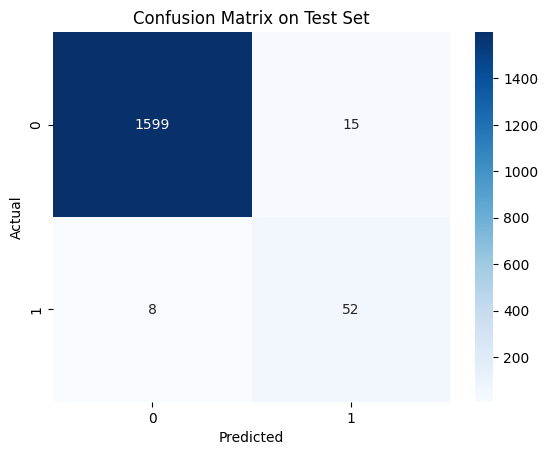

In [128]:
def rf_param_space(trial):
    return {
    "n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
    "max_depth": trial.suggest_int("max_depth", 3, 10),
    "class_weight": trial.suggest_categorical("class_weight", ["balanced_subsample", "balanced"]),
    "random_state": RANDOM_STATE,
}

best_params_rf, best_score = cross_val_train_optuna(X_train, y_train, RandomForestClassifier, rf_param_space)
final_model_rf, results_rf  = fit_final_model(RandomForestClassifier, X_train, y_train, X_test, y_test, best_params_rf)

C:\Users\Furka\AppData\Local\Temp\ipykernel_11552\2318615075.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in top_features], y=[f[0] for f in top_features], palette="viridis")


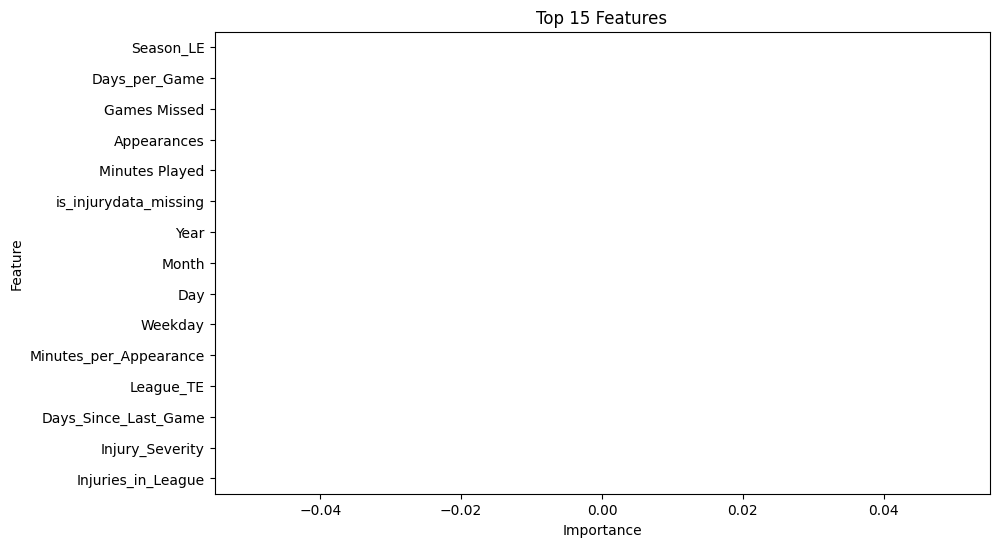

In [143]:
plot_top_features(final_model_rf, X_train.columns.tolist(), top_n=15)

## LGBM

[I 2024-12-15 20:48:43,086] A new study created in memory with name: no-name-99903b73-0ae0-4013-b4b4-6ded7b8f9bb1
[I 2024-12-15 20:48:43,517] Trial 0 finished with value: 0.9971545604025825 and parameters: {'learning_rate': 0.11602454632192398, 'num_leaves': 36, 'max_depth': 7, 'feature_fraction': 0.6084486490018122, 'bagging_fraction': 0.836578792113659, 'bagging_freq': 5, 'min_child_samples': 29, 'scale_pos_weight': 314.3778307951667}. Best is trial 0 with value: 0.9971545604025825.
[I 2024-12-15 20:48:43,664] Trial 1 finished with value: 0.9959401554660811 and parameters: {'learning_rate': 0.010710270613950194, 'num_leaves': 140, 'max_depth': 3, 'feature_fraction': 0.7031349975513909, 'bagging_fraction': 0.6332063708529226, 'bagging_freq': 7, 'min_child_samples': 10, 'scale_pos_weight': 5.146099353285967}. Best is trial 1 with value: 0.9959401554660811.
[I 2024-12-15 20:48:43,924] Trial 2 finished with value: 0.9967004542468362 and parameters: {'learning_rate': 0.20361094897529303, 

Best Parameters for RandomForest: {'learning_rate': 0.012508971990054076, 'num_leaves': 112, 'max_depth': 3, 'feature_fraction': 0.794453735205253, 'bagging_fraction': 0.6898076185181709, 'bagging_freq': 3, 'min_child_samples': 45, 'scale_pos_weight': 115.41107721827186}
Best AUC-Score for RandomForest: 0.9957
Fitting final model...
[LightGBM] [Warning] feature_fraction is set=0.794453735205253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.794453735205253
[LightGBM] [Warning] bagging_fraction is set=0.6898076185181709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6898076185181709
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.794453735205253, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.794453735205253
[LightGBM] [Warning] baggi

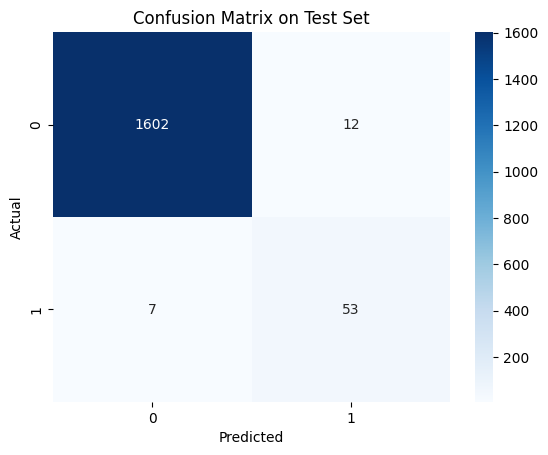

In [132]:
def lgbm_param_space(trial):
    return {
        "objective": "binary",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0, log=True),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0, log=True),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 100),
        "random_state": RANDOM_STATE,
        # "early_stopping_rounds": 100,
        "verbose":-1,
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 500, log=True),
}

best_params_lgbm, best_score_lgbm = cross_val_train_optuna(X_train, y_train, lgb.LGBMClassifier, lgbm_param_space)
final_model__lgbm, results_lgbm  = fit_final_model(lgb.LGBMClassifier, X_train, y_train, X_test, y_test, best_params_lgbm)

C:\Users\Furka\AppData\Local\Temp\ipykernel_11552\2318615075.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in top_features], y=[f[0] for f in top_features], palette="viridis")


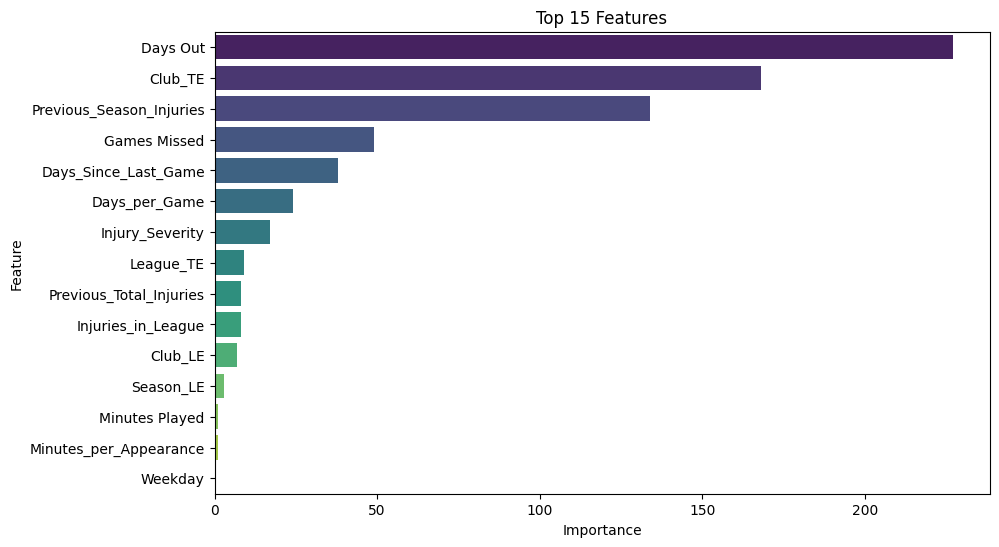

In [141]:
plot_top_features(final_model__lgbm, X_train.columns.tolist(), top_n=15)

## Xgboost

[I 2024-12-15 20:50:05,728] A new study created in memory with name: no-name-40eb59ec-6681-40d6-9295-668825bef093
c:\Users\Furka\anaconda3\envs\llm4ts\lib\site-packages\xgboost\core.py:160: UserWarning: [20:50:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
[I 2024-12-15 20:50:09,856] Trial 0 finished with value: 0.9979488788070198 and parameters: {'learning_rate': 0.07542059619489258, 'max_depth': 7, 'n_estimators': 640, 'subsample': 0.7478867902761844, 'colsample

Best Parameters for RandomForest: {'learning_rate': 0.188888674477072, 'max_depth': 9, 'n_estimators': 948, 'subsample': 0.7198348918682058, 'colsample_bytree': 0.7995944152632354, 'gamma': 1.2974016512902873e-05, 'scale_pos_weight': 2.4242830533396162}
Best AUC-Score for RandomForest: 0.9976
Fitting final model...
Evaluation Metrics:
               precision   recall  f1-score     support  accuracy_score
0              0.988964  0.99938  0.994145  1614.00000         0.98865
1              0.976744  0.70000  0.815534    60.00000         0.98865
accuracy       0.988650  0.98865  0.988650     0.98865         0.98865
macro avg      0.982854  0.84969  0.904839  1674.00000         0.98865
weighted avg   0.988526  0.98865  0.987743  1674.00000         0.98865


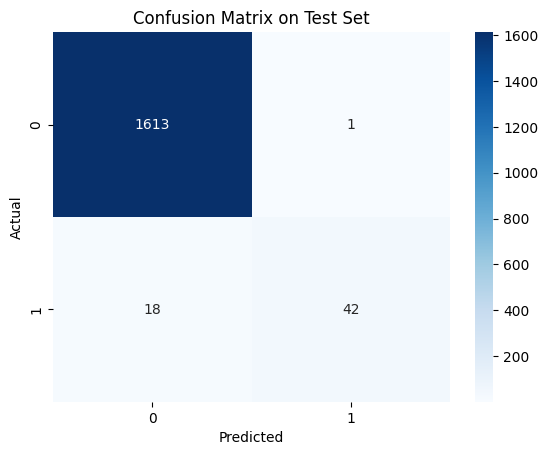

In [133]:
def xgb_param_space(trial):
    return {
        "objective": "binary:logistic",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "random_state": RANDOM_STATE,
        "device": "cuda",
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1, 2000, log=True),
}

best_params_xgb, best_score_xgb = cross_val_train_optuna(X_train, y_train, xgb.XGBClassifier, xgb_param_space)
final_model_xgb, results_xgb  = fit_final_model(xgb.XGBClassifier, X_train, y_train, X_test, y_test, best_params_xgb)

C:\Users\Furka\AppData\Local\Temp\ipykernel_11552\2318615075.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[f[1] for f in top_features], y=[f[0] for f in top_features], palette="viridis")


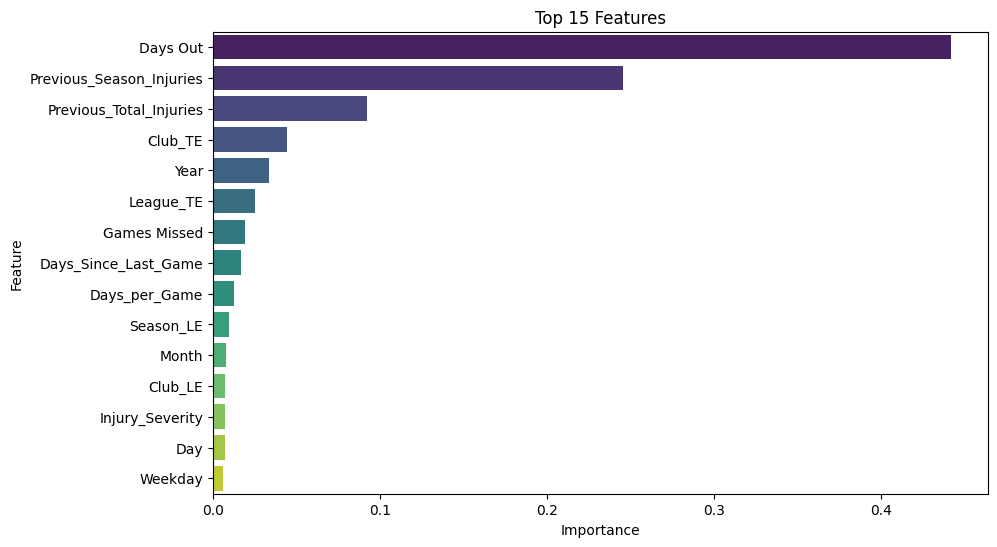

In [142]:
plot_top_features(final_model_xgb, X_train.columns.tolist(), top_n=15)